# 1. Libraries and Imports

In [1]:
!pip install trackio -qq
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
import torchmetrics
from torchvision import datasets, transforms
import trackio
import os
from kaggle_secrets import UserSecretsClient
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.0/875.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
user_secrets = UserSecretsClient()
os.environ['HF_TOKEN']  = user_secrets.get_secret("hftk")

# 2. EDA, Augmentaion, Dataloaders

In [3]:
DATA_DIR = Path('/kaggle/input/sep-25-dl-gen-ai-nppe-1/face_dataset')
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [4]:
print(round(train_df['gender'].value_counts(normalize=True) * 100,0))

gender
1    75.0
0    25.0
Name: proportion, dtype: float64


* **There is a class imbalance**

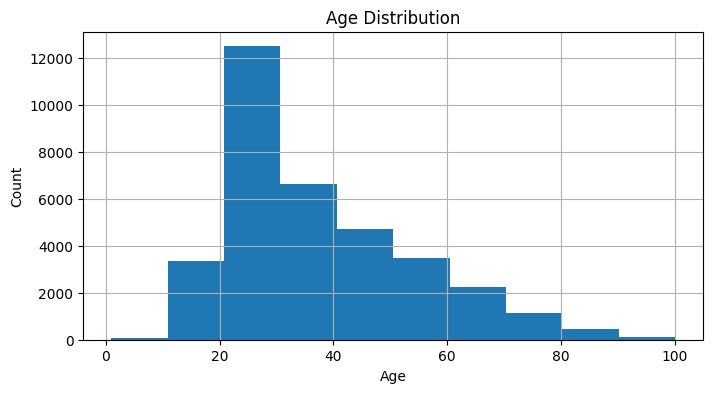

In [5]:
plt.figure(figsize=(8,4))
train_df['age'].hist()
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**Analyzing Image Sizes**

In [6]:
def size_of_images(csv):
    df = pd.read_csv(DATA_DIR / csv)
    widths, heights = [], []

    for x in tqdm(df['full_path'], desc=f"Checking {csv}"):
        img_path = DATA_DIR / x
        try:
            with Image.open(img_path) as img:
                w, h = img.size 
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"Failed {img_path}: {e}")

    widths = np.array(widths)
    heights = np.array(heights)

    print(f"\n[{csv}]")
    print(f"Width  -> min: {widths.min()}, max: {widths.max()}, avg: {widths.mean():.2f}")
    print(f"Height -> min: {heights.min()}, max: {heights.max()}, avg: {heights.mean():.2f}")

    return widths, heights

# train_w, train_h = size_of_images('train.csv')
# test_w, test_h = size_of_images('test.csv')

In [7]:
mean = [0.4775, 0.4121, 0.3806]
std = [0.2555, 0.2341, 0.2284]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),           
    transforms.Normalize(mean=mean, std=std) 
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),           
    transforms.Normalize(mean=mean, std=std) 
])

In [8]:
class AGDataset(Dataset):
    def __init__(self, df, data_dir, transform=train_transform):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.age_mean = self.df['age'].mean()
        self.age_std = self.df['age'].std()
        self.df['age_normalized'] = (self.df['age'] - self.age_mean) / self.age_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_dir / row['full_path']
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        gender = torch.tensor(row['gender']).long()
        age = torch.tensor(row['age_normalized']).float()

        return image, gender, age

In [9]:
class AGTestDataset(Dataset):
    def __init__(self, df, data_dir, transform=test_transform):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_dir / row['full_path']
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, str(row['id'])


In [10]:
train_df_split, val_df_split = train_test_split(train_df, test_size=0.05, random_state=42, stratify=train_df['gender'])

train_dataset = AGDataset(train_df_split, DATA_DIR, transform=train_transform)
val_dataset = AGDataset(val_df_split, DATA_DIR, transform=test_transform)
test_dataset = AGTestDataset(test_df, DATA_DIR, transform=test_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

**Code used for finding mean and standard deviation**

In [11]:
# mean = 0.
# std = 0.
# nb_samples = 0

# for images, _, _ in train_loader:
#     batch_samples = images.size(0)
#     data = images.view(batch_samples, 3, -1)  
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print("Mean:", mean)
# print("Std:", std)


# 3. Model Architecture - Finetuned

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes_gender=2):
        super().__init__()
        self.backbone = models.efficientnet_b3(weights='IMAGENET1K_V1')
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity() 

        self.fc_age = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        self.fc_gender = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes_gender)
        )

    def forward(self, x):
        x = self.backbone(x)
        age = self.fc_age(x).squeeze(1)
        gender = self.fc_gender(x)
        return age, gender


# 4. Model Architecture - From Scratch

In [13]:
# class CNN(nn.Module):
#     def __init__(self, num_classes_age=1, num_classes_gender=2):
#         super().__init__()

#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3),  
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),                  

#             nn.Conv2d(32, 64, kernel_size=3), 
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),                  

#             nn.Conv2d(64, 128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2),                  

        #     nn.Conv2d(128, 256, kernel_size=3),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2),                   

        #     nn.Conv2d(256, 512, kernel_size=3),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(inplace=True),
        #     nn.AdaptiveAvgPool2d((1, 1))      
        # )

        
        # self.fc_age = nn.Sequential(
        #     nn.Linear(512, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(128, 1)
        # )

    #     self.fc_gender = nn.Sequential(
    #         nn.Linear(512, 128),
    #         nn.ReLU(),
    #         nn.Dropout(0.3),
    #         nn.Linear(128, num_classes_gender)
    #     )

    # def forward(self, x):
    #     x = self.features(x)
    #     x = torch.flatten(x, 1)
    #     age = self.fc_age(x).squeeze(1)
    #     gender = self.fc_gender(x)
        # return age, gender

# 5. Loss function and Optimizer

In [14]:
# model = CNN() 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# criterion_age = nn.MSELoss()
# criterion_gender = nn.CrossEntropyLoss()
# print("Done")

# 6. Training Code (with trackio and model save)

In [15]:
# EPOCHS = 5

# trackio.init(
#     project="25-t3-nppe1",                   
#     space_id="Hariharan1703/dlgenai-nppe",            
#     name="efficientnet",
#     group="finetuned"
# )               

# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0.0
#     loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=False)

#     for images, genders, ages in loop:
#         images, genders, ages = images.to(device), genders.to(device), ages.to(device)

#         optimizer.zero_grad()
#         pred_age, pred_gender = model(images)

    #     loss_age = torch.sqrt(criterion_age(pred_age, ages))
    #     loss_gender = criterion_gender(pred_gender, genders)
    #     loss = loss_age + loss_gender
    #     loss.backward()
    #     optimizer.step()

    #     running_loss += loss.item()
    #     loop.set_postfix({
    #         "Loss": f"{loss.item():.4f}",
    #         "Age": f"{loss_age.item():.4f}",
    #         "Gender": f"{loss_gender.item():.4f}"
    #     })

    # epoch_loss = running_loss / len(train_loader)
    
    # model.eval()
    # true_gender, pred_gender_list = [], []
    # true_age, pred_age_list = [], []

    # with torch.no_grad():
    #     for images, genders, ages in val_loader:
    #         images, genders, ages = images.to(device), genders.to(device), ages.to(device)
    #         age_out, gender_out = model(images)

    #         true_age_denorm = ages.cpu().numpy() * train_dataset.age_std + train_dataset.age_mean
    #         pred_age_denorm = age_out.cpu().numpy() * train_dataset.age_std + train_dataset.age_mean

    #         true_age.extend(true_age_denorm)
    #         pred_age_list.extend(pred_age_denorm)

    #         preds = torch.argmax(gender_out, 1)
    #         true_gender.extend(genders.cpu().numpy())
    #         pred_gender_list.extend(preds.cpu().numpy())

    
    # rmse_val = np.sqrt(np.mean((np.array(true_age) - np.array(pred_age_list)) ** 2))
    # age_score = 1 - min(rmse_val, 30) / 30
    # gender_f1 = f1_score(true_gender, pred_gender_list, average='macro')
    # final_score = 2 * age_score * gender_f1 / (age_score + gender_f1)
    
#     trackio.log({
#         "epoch": epoch+1,
#         "train_loss": epoch_loss,
#         "V_rmse_age": rmse_val,
#         "V_age_score": age_score,
#         "V_gender_score": gender_f1,
#         "V_final_score": final_score})

#     print(f"Epoch [{epoch+1}/{EPOCHS}] | "
#           f"Train Loss: {epoch_loss:.4f} | "
#           f"RMSE (Age): {rmse_val:.3f} | "
#           f"Score (Age): {age_score:.4f} | "
#           f"Score (Gender): {gender_f1:.4f} | "
#           f"Final Score: {final_score:.4f}")

# trackio.finish()

In [16]:
MODEL_PATH="/kaggle/input/efficientnet/pytorch/default/1/model.pth"
#torch.save(model.state_dict(), MODEL_PATH)

# 7. Inference Code

# *7.1 Load Saved Model*

In [17]:
model = CNN() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()
print("Done")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 183MB/s]


Done


# *7.2 Test Prediction and CSV Creation*

In [18]:
submission = []
with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        age_out, gender_out = model(images)

        pred_age = age_out.cpu().numpy() * train_dataset.age_std + train_dataset.age_mean
        pred_gender = torch.argmax(gender_out, dim=1).cpu().numpy()

        for i, _id in enumerate(ids):
            submission.append({
                "id": str(_id),             
                "gender": int(pred_gender[i]),
                "age": float(pred_age[i])
            })
submission_df = pd.DataFrame(submission)
submission_df.to_csv("submission.csv", index=False)
print("Done")

Done
